In [1]:
from ultralytics import YOLO
import string

from random import shuffle
import random
from glob import glob
import cv2
import os
import numpy as np
import PIL
from PIL import ImageFont, ImageDraw, Image
import time
import matplotlib.pyplot as plt 

In [2]:
def convert_img_path_to_label_path(img_paths):
    label_paths = []
    for img_path in img_paths:
        label_path = img_path.replace('images', 'labels')
        label_path = label_path.replace('.jpg', '.txt')
        label_paths.append(label_path)
    return label_paths

def plot_predictions_on_img(image, result, class_name_dict, box_colors):
    boxes = result.boxes
    for box in boxes:
        class_number = box.cls.cpu().detach().tolist()[0]
        class_name = class_name_dict[class_number]
        class_color = box_colors[int(class_number)]

        xmin, ymin, xmax, ymax = box.xyxy[0]  
        conf = box.conf.cpu().detach().tolist()[0]

        start_point = (int(xmin), int(ymin)) 
        end_point = (int(xmax), int(ymax))

        # Use simsum.ttc font
        fontpath = "SegUIVar.ttf"     
        font = ImageFont.truetype(fontpath, 20)
        img_pil = Image.fromarray(image)
        draw = ImageDraw.Draw(img_pil)
        draw.text((int(xmin), int(ymin)), f"{conf:0.2f}", font=font, fill=(0,0,0), stroke_width=1, stroke_fill=(255,255,255))
        image = np.array(img_pil)
        image = cv2.rectangle(image, start_point, end_point, color=class_color, thickness=2)

        #cv2.imwrite(os.path.join(predict_img_dir, os.path.basename(result.path)), image)
    return image

In [3]:

def format_class_names(result):
    class_name_dict = result.names
    for key, value in class_name_dict.items():
        class_name_dict[key] = value.replace('_', ' ')
    return(class_name_dict)

def get_annnotated_bboxes(label_path):
    labels = []
    with open(label_path) as f:
        label = f.read()
        coords = label.split('\n')
        for coord in coords:
            bbox = []
            if coord != "":
                c = coord.split(' ')
                bbox.append(int(c[0]))
                bbox.append(float(c[1]))
                bbox.append(float(c[2])) 
                bbox.append(float(c[3]))
                bbox.append(float(c[4]))
                labels.append(bbox)
    return labels

def convert_yolo_xyxy(box, shape):
    # Convert bbox coordinates to pixel values
    x_center = int(box[0] * shape[1])
    y_center = int(box[1] * shape[0])
    width = int(box[2] * shape[1])  
    height = int(box[3] * shape[0])

    # Calculate bounding box coordinates
    xmin = x_center - width//2
    ymin = y_center - height//2
    xmax = x_center + width//2
    ymax = y_center + height//2
    return [xmin, ymin, xmax, ymax]

def plot_annotations_on_img(image, label_path, box_colors):
    labels = get_annnotated_bboxes(label_path)
    for label in labels:
        class_number = label[0]
        #class_name = class_name_dict[class_number]
        class_color = box_colors[int(class_number)]
        label = convert_yolo_xyxy(label[1:], image.shape)
        xmin, ymin, xmax, ymax = label
        # Draw bounding box 
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)    
        # Use simsum.ttc font
        #fontpath = "SegUIVar.ttf"     
        #font = ImageFont.truetype(fontpath, 24)
        #img_pil = Image.fromarray(image)
        #draw = ImageDraw.Draw(img_pil)
        #draw.text((int(xmin), int(ymin)), f"{class_name}", font=font)#, fill=(b, g, r, a)) 
        #image = np.array(img_pil)
        image = cv2.rectangle(image, start_point, end_point, color=class_color, thickness=2)
    return image

In [4]:
model_path="/work/csr33/object_detection/runs/detect/train_w_tuned_hyperparameters3/weights/best.pt"
# Load a pretrained YOLOv8n model
model = YOLO(model_path)

In [5]:
test_img_dir = "/work/csr33/ast/datasets/yolo/images/test"
test_img_paths = glob(test_img_dir+"/*")

In [6]:
img_paths = [
             '/work/csr33/ast/datasets/yolo/images/test/m_4311631_se_11_060_20190714_00_00.jpg',
            '/work/csr33/ast/datasets/yolo/images/test/m_2909523_nw_15_060_20201130_11_15.jpg',
            '/work/csr33/ast/datasets/yolo/images/test/m_3509603_nw_14_060_20190812_22_06.jpg',
             '/work/csr33/ast/datasets/yolo/images/test/m_2909515_se_15_060_20201130_20_14.jpg',

#'/work/csr33/ast/datasets/yolo/images/test/m_4709521_ne_15_060_20190723_22_06.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_4108321_sw_17_060_20190825_19_00.jpg',

#'/work/csr33/ast/datasets/yolo/images/test/m_3008845_nw_16_060_20181204_08_04.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_3509602_se_14_060_20190812_04_14.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_3509603_nw_14_060_20190812_15_10.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_4108721_sw_16_060_20180707_12_06.jpg',


#'/work/csr33/ast/datasets/yolo/images/test/m_3609659_sw_14_060_20190812_20_01.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_3509737_nw_14_060_20190711_13_16.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_3809016_nw_15_060_20190923_14_14.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_3009126_se_15_060_20190904_11_20.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_4812211_ne_10_060_20191010_16_01.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_2909532_sw_15_060_20181210_15_06.jpg',
#'/work/csr33/ast/datasets/yolo/images/test/m_3308753_nw_16_060_20191023_01_03.jpg',
]

                
label_paths = convert_img_path_to_label_path(img_paths)

In [44]:
img_paths[2]

'/work/csr33/ast/datasets/yolo/images/test/m_3509602_se_14_060_20190812_04_14.jpg'

Plot Original, Annotated, Detected Images

In [47]:
indicies = [i for i in range(len(test_img_paths))]
shuffle(indicies)
images = [test_img_paths[i] for i in indicies]
rand_indices = random.sample(range(len(images)), 10)
img_paths = [images[i] for i in rand_indices]
label_paths = convert_img_path_to_label_path(img_paths)


0: 640x640 26 closed roof tanks, 1: 640x640 9 closed roof tanks, 1 external floating roof tank, 13 spherical tanks, 2: 640x640 6 external floating roof tanks, 3: 640x640 6 closed roof tanks, 6531.7ms
Speed: 2.2ms preprocess, 1632.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


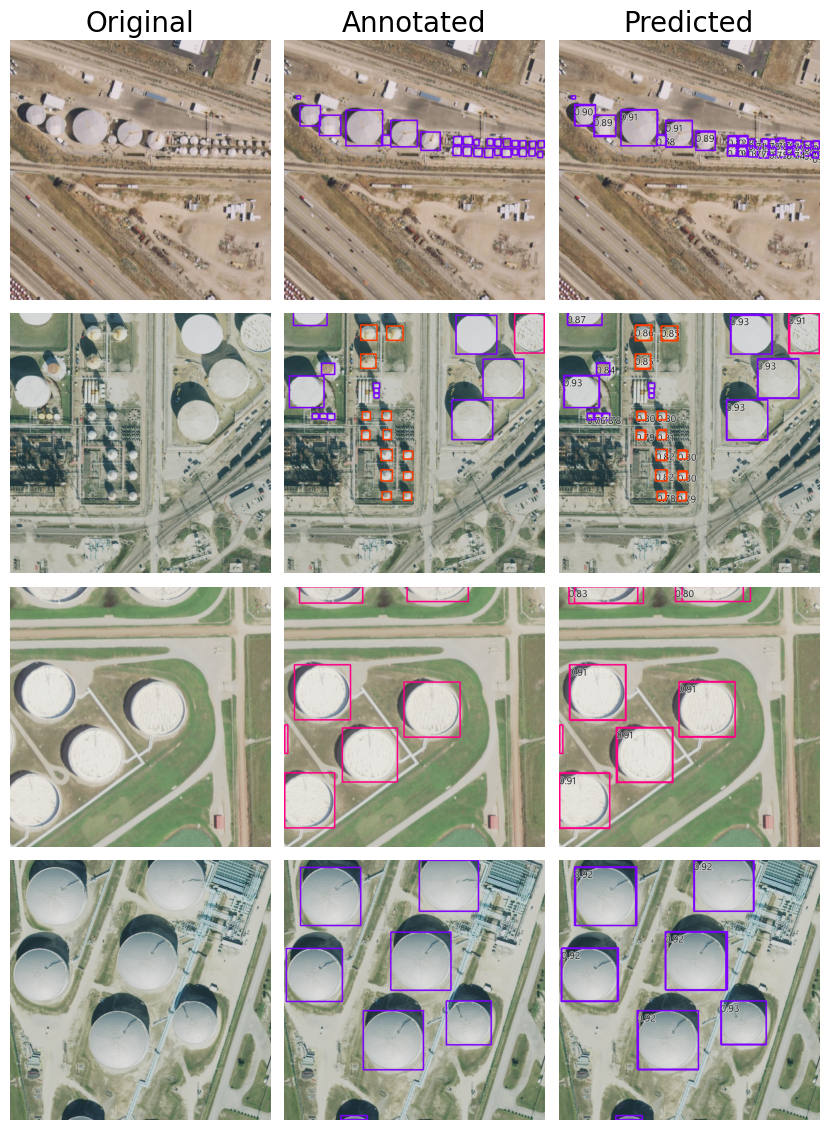

In [32]:
# Run inference on 'bus.jpg' 
alpha_lower = list(string.ascii_lowercase)
predict_img_dir = "/hpc/home/csr33/prediction_imgs"#"/hpc/group/borsuklab/csr33/object_detection/prediction_imgs"
#bgr
box_colors = [(255, 0, 124, 0.8),(132, 0, 255, 0.8),(0, 60, 255, 0.8)]
results = model(img_paths, conf=0.5)  # results list

fig,axes = plt.subplots(nrows=len(img_paths), ncols=3, figsize=(3*3,len(img_paths)*3))
for i, (img_path, label_path, result) in enumerate(zip(img_paths,label_paths,results)):
    
    class_name_dict = format_class_names(result)
    image = cv2.imread(img_path)
    axes[i,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
        
    anno_image = plot_annotations_on_img(image, label_path, box_colors)
    axes[i,1].imshow(cv2.cvtColor(anno_image, cv2.COLOR_BGR2RGB)) 

    pred_image = plot_predictions_on_img(image, result, class_name_dict, box_colors)
    axes[i,2].imshow(cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB))
    
    axes[i,0].set_axis_off()
    axes[i,1].set_axis_off()
    axes[i,2].set_axis_off()
    
# set column/row names
axes[0,0].set_title(f"Original",fontsize=20)
axes[0,1].set_title(f"Annotated",fontsize=20)
axes[0,2].set_title(f"Predicted",fontsize=20)


            
plt.subplots_adjust(left=0.05,bottom=0.05, right=0.95, top=0.95, 
                    wspace=0.05, hspace=0.05)
plt.show()
fig.savefig("/hpc/home/csr33/ast_object_detection/original_annotation_predictions.png", dpi=900, pad_inches=0.25)

Plot Original, Annotated, Detected Images

In [10]:
train_img_dir = "/work/csr33/ast/datasets/yolo/images/train"
train_img_paths = glob(train_img_dir+"/*")

In [11]:
train_indicies = [i for i in range(len(train_img_paths))]
shuffle(train_indicies)
train_images = [train_img_paths[i] for i in train_indicies]
rand_indices = random.sample(range(len(train_images)), 10)
train_img_paths = [train_images[i] for i in rand_indices]

In [12]:
train_label_paths = convert_img_path_to_label_path(train_img_paths)

In [13]:
##### Run inference on 'bus.jpg' 
predict_img_dir = "/hpc/home/csr33/prediction_imgs"#"/hpc/group/borsuklab/csr33/object_detection/prediction_imgs"
#bgr
box_colors = [(255, 0, 124, 0.8),(132, 0, 255, 0.8), (0, 60, 255, 0.8)]

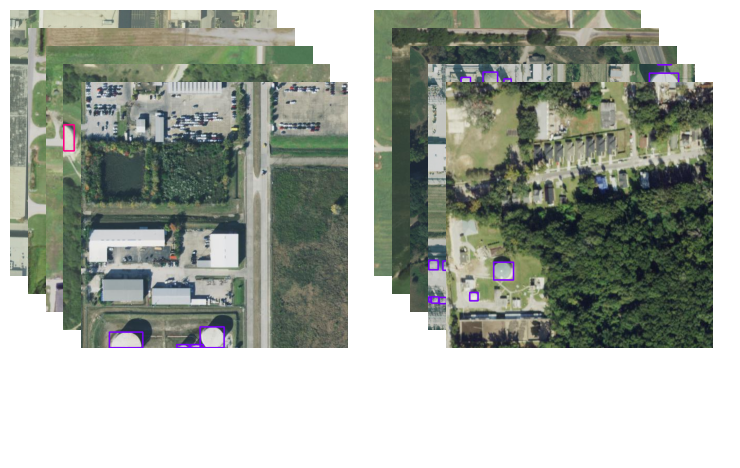

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols =2,  figsize=(8,4))
ax = axes[0]
for i, (img_path, label_path) in enumerate(zip(train_img_paths[:5], train_label_paths[:5])):

    #newax = fig.add_axes([0.1*i, 0.5 - 0.1*i, 2, 2])#, anchor='SE')
    axx = ax.inset_axes([0.05*i, 0.5 - 0.05*i, 0.75, 0.75])#, anchor='SE')
    
    image = cv2.imread(img_path)    
    anno_image = plot_annotations_on_img(image, label_path, box_colors)
    axx.imshow(cv2.cvtColor(anno_image, cv2.COLOR_BGR2RGB)) 
    
    axx.axis('off')
ax.axis("off")
    
ax = axes[1]  
for i, (img_path, label_path) in enumerate(zip(train_img_paths[5:], train_label_paths[5:])):

    #newax = fig.add_axes([0.1*i, 0.5 - 0.1*i, 2, 2])#, anchor='SE')
    axx = ax.inset_axes([0.05*i, 0.5 - 0.05*i, 0.75, 0.75])#, anchor='SE')
    
    image = cv2.imread(img_path)    
    anno_image = plot_annotations_on_img(image, label_path, box_colors)
    axx.imshow(cv2.cvtColor(anno_image, cv2.COLOR_BGR2RGB)) 
    
    axx.axis('off')
ax.axis("off")
# set column/row names
#axes.axis("off")

plt.subplots_adjust(left=0.05,bottom=0.05, 
                    right=0.95, top=0.95, 
                    wspace=0.025, 
                    hspace=0.025)
plt.show()
fig.savefig("/hpc/home/csr33/ast_object_detection/annotated_imgs.jpg", dpi=900, pad_inches=0.25)